In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import style
style.use('ggplot')   #图画风格
plt.rcParams['font.sans-serif'] = ['SimHei']  #字体风格
plt.rcParams['axes.unicode_minus'] = False    #是否中文字体变小
plt.rcParams['figure.figsize'] = (12,7)       #图像大小

In [18]:
FILE_NAME = '../input/all_data.csv'  
START_POINT = '2015/1/1 0:00:00'     #第一个时刻点
def load_data(file_name,start_point):
    source_df = pd.read_csv(file_name,index_col=0)   #读入csv文件
    index_col = pd.date_range(start_point,periods=len(source_df),freq='h')   #产生日期index
    source_df = pd.DataFrame(np.array(source_df),index=index_col,columns=source_df.columns) #产生标准日期格式的DataFrame
    return source_df
source_df = load_data(FILE_NAME,START_POINT)
print("产生的日期格式like this: ",source_df.index[0])
print("dataframe de 第一条记录如下:")
source_df.head(1)

产生的日期格式like this:  2015-01-01 00:00:00
dataframe de 第一条记录如下:


,zhexi_in,xiaoxi_out,lengshuijiang_add,xinhua_add,zhexi_add
2015-01-01,180.475,67.0,0.0,0.0,0.0


## 1.查看分布情况

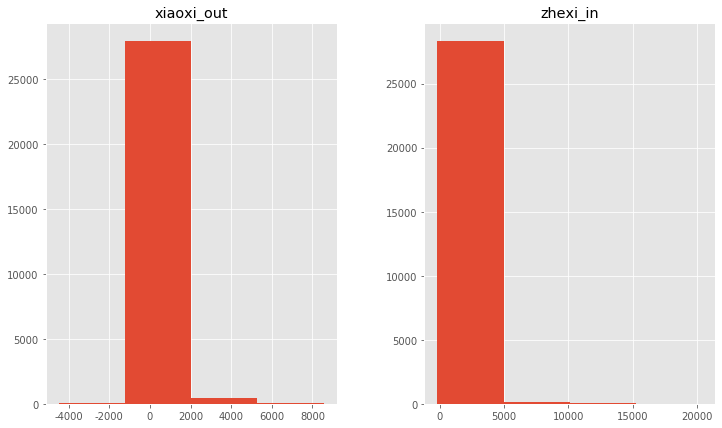

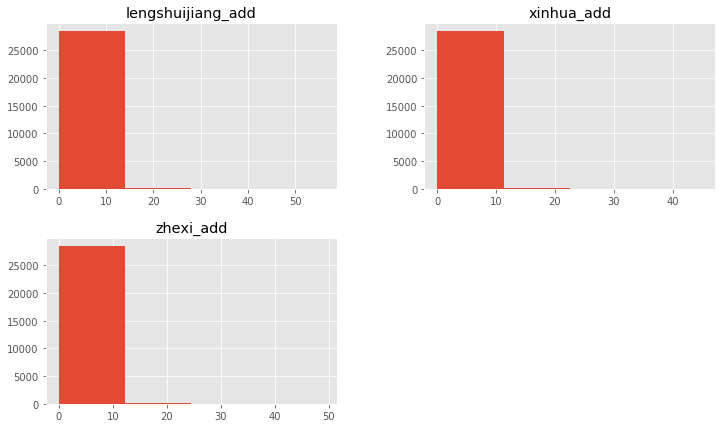

In [19]:
def show_distribute(source_df):
    source_df[['zhexi_in','xiaoxi_out']].hist(bins=4)  #上下游进出水量分布情况
    plt.show()
    source_df[['lengshuijiang_add','xinhua_add','zhexi_add']].hist(bins=4) #降雨信息分布情况
    plt.show()
show_distribute(source_df)

## 2.异常点处理
###### 图中进水量和出水量产生负值是因为，水库设置了一个水位线，低于此水位线为负，高于为正。
###### 在此处理将这些负值重新赋值为0

In [20]:
def handle_outlier_points(source_df):
    #replace the negetive number in column 'zhexi_in' with zero
    print('zhexi in negtive points num:',source_df[source_df['zhexi_in'] < 0]['zhexi_in'].count())
    # source_df.ix[source_df['zhexi_in'] < 0,'zhexi_in'] = 0
    source_df['zhexi_in'] = source_df['zhexi_in'].apply(lambda x:x if(x>0) else 0)
    print('zhexi_in negtive points num:',source_df[source_df['zhexi_in'] < 0]['zhexi_in'].count())

    print('xiaoxi out negtive points num:',source_df[source_df['xiaoxi_out'] < 0]['xiaoxi_out'].count())
    # source_df.ix[source_df['xiaoxi_out'] < 0,'xiaoxi_out'] = 0
    source_df['xiaoxi_out'] = source_df['xiaoxi_out'].apply(lambda x:x if(x>0) else 0)
    print('xiaoxi out negtive points num:',source_df[source_df['xiaoxi_out'] < 0]['xiaoxi_out'].count())
    return source_df
source_df = handle_outlier_points(source_df)

zhexi in negtive points num: 10
zhexi_in negtive points num: 0
xiaoxi out negtive points num: 93
xiaoxi out negtive points num: 0


## 3.空值处理

In [21]:
def handle_nan(source_df):
    source_df.fillna(axis=0,method='ffill')  #纵向用缺失值前面的值替换缺失值"
    print(source_df.zhexi_in.notnull().value_counts())
    print(source_df.xiaoxi_out.notnull().value_counts())
    print(source_df.lengshuijiang_add.notnull().value_counts())
    print(source_df.xinhua_add.notnull().value_counts())
    print(source_df.zhexi_add.notnull().value_counts())
    return source_df
source_df = handle_nan(source_df)

True    28501
Name: zhexi_in, dtype: int64
True    28501
Name: xiaoxi_out, dtype: int64
True    28501
Name: lengshuijiang_add, dtype: int64
True    28501
Name: xinhua_add, dtype: int64
True    28501
Name: zhexi_add, dtype: int64


## 4.构造特征  
a.最近24小时的水量平均值特征  
b.最近24小时的降雨量总和特征，以及降雨强度类别特征  
c.最近period个进水量值、降雨量值  
d.上游period个时刻的出水量，经过offset个小时的延迟，影响到当前时刻

In [22]:
# a.最近24小时的水量平均值特征  
def water_avg(source_df):
    source_df['zhexi_in_day_avg'] = source_df[['zhexi_in']].rolling(window=24).mean()
    source_df['xiaoxi_out_day_avg'] = source_df[['xiaoxi_out']].rolling(window=24).mean()
    return source_df
source_df = water_avg(source_df)

In [23]:
# b.最近24小时的降雨量总和特征，以及降雨强度类别特征 
def rainfall_total(source_df):
    source_df['lengshuijiang_add_day_rainfall_total'] = source_df[['lengshuijiang_add']].rolling(window=24).sum()
    source_df['xinhua_add_add_day_rainfall_total'] = source_df[['xinhua_add']].rolling(window=24).sum()
    source_df['zhexi_add_day_rainfall_total'] = source_df[['zhexi_add']].rolling(window=24).sum()
    source_df = source_df.dropna()
    return source_df
source_df = rainfall_total(source_df)

In [24]:
source_df.head(1)

,zhexi_in,xiaoxi_out,lengshuijiang_add,xinhua_add,zhexi_add,zhexi_in_day_avg,xiaoxi_out_day_avg,lengshuijiang_add_day_rainfall_total,xinhua_add_add_day_rainfall_total,zhexi_add_day_rainfall_total
2015-01-01 23:00:00,127.582,198.0,0.0,0.0,0.0,155.391583,118.333333,0.0,0.0,0.0


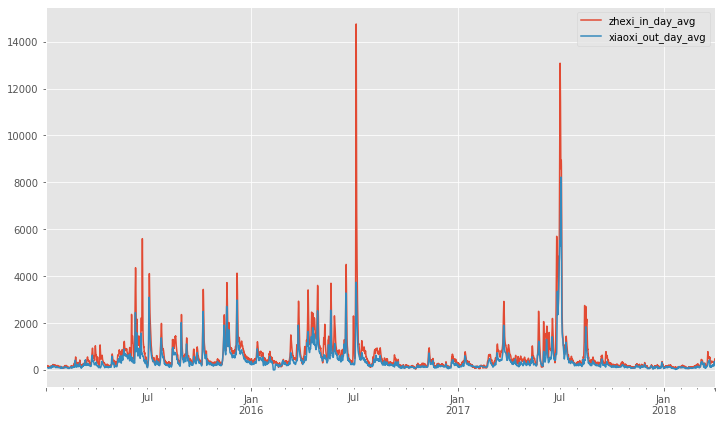

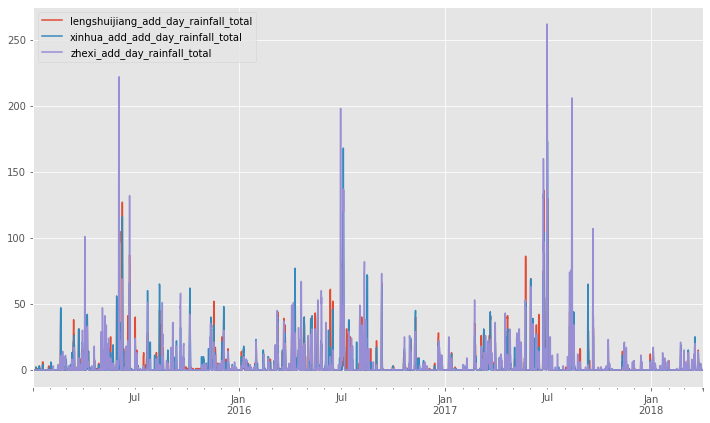

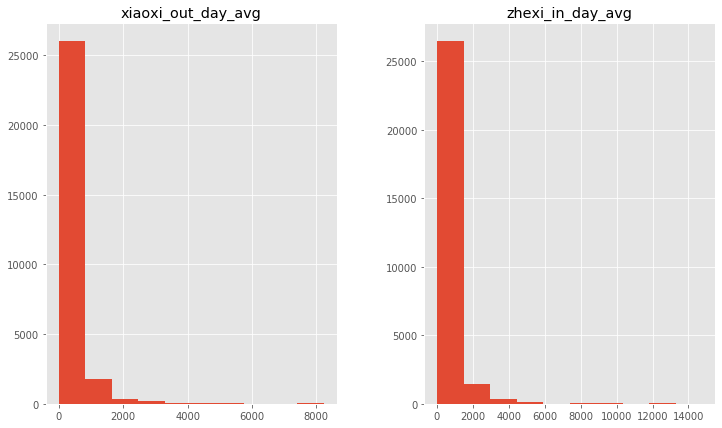

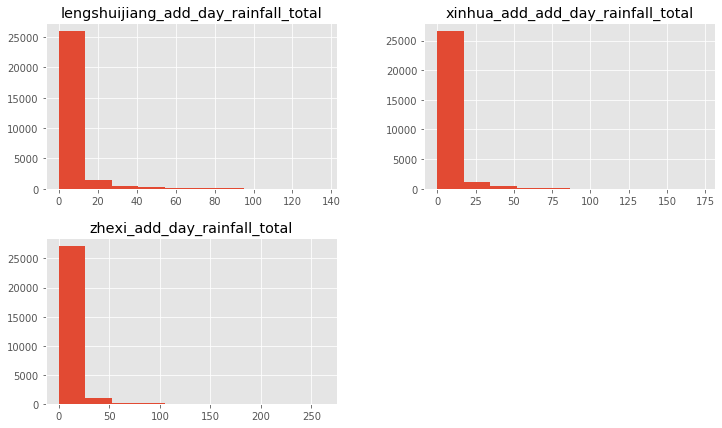

In [25]:
source_df[['zhexi_in_day_avg','xiaoxi_out_day_avg']].plot()
plt.show()
source_df[['lengshuijiang_add_day_rainfall_total','xinhua_add_add_day_rainfall_total','zhexi_add_day_rainfall_total']].plot()
plt.show()
source_df[['zhexi_in_day_avg','xiaoxi_out_day_avg']].hist()
plt.show()
source_df[['lengshuijiang_add_day_rainfall_total','xinhua_add_add_day_rainfall_total','zhexi_add_day_rainfall_total']].hist()
plt.show()

In [26]:
def rainfall_level_determination(rainfall):
    if rainfall < 0.0:
        return -1;
    elif rainfall < 10.0:  #小雨
        return 'level1';
    elif rainfall < 25.0:  #中雨
        return 'level2';
    elif rainfall < 50.0:  #大雨
        return 'level3';
    elif rainfall < 100.0: #暴雨
        return 'level4';
    elif rainfall < 250.0: #大暴雨
        return 'level5';
    else:                  #特大暴雨
        return 'level6';
def rainfall_heavy(source_df):
    for record_index in list(source_df.index):
        source_df.ix[record_index,'lengshuijiang_add_level'] = rainfall_level_determination(
            source_df.ix[record_index,'lengshuijiang_add_day_rainfall_total'])
        source_df.ix[record_index,'xinhua_add_level'] = rainfall_level_determination(
            source_df.ix[record_index,'xinhua_add_add_day_rainfall_total'])
        source_df.ix[record_index,'zhexi_add_level'] = rainfall_level_determination(
            source_df.ix[record_index,'zhexi_add_day_rainfall_total'])
    return pd.get_dummies(source_df)
source_df = rainfall_heavy(source_df)
source_df.head(1)

/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,zhexi_in,xiaoxi_out,lengshuijiang_add,xinhua_add,zhexi_add,zhexi_in_day_avg,xiaoxi_out_day_avg,lengshuijiang_add_day_rainfall_total,xinhua_add_add_day_rainfall_total,zhexi_add_day_rainfall_total,...,xinhua_add_level_level2,xinhua_add_level_level3,xinhua_add_level_level4,xinhua_add_level_level5,zhexi_add_level_level1,zhexi_add_level_level2,zhexi_add_level_level3,zhexi_add_level_level4,zhexi_add_level_level5,zhexi_add_level_level6
2015-01-01 23:00:00,127.582,198.0,0.0,0.0,0.0,155.391583,118.333333,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# c.最近period个进水量值、降雨量值  
# d.上游period个时刻的出水量，经过offset个小时的延迟，影响到当前时刻

def create_shift_features(data,shift_columns,offsets=[0,0,48,48],periods=[12,12,12,12]):
    for i in range(1,len(shift_columns)+1):
        column,offset,period = shift_columns[i-1],offsets[i-1],periods[i-1]
        for j in range(1,period+1):
            data[f'{column}_shift{offset}_{j}'] = data[column].shift((offset+j))
    return data.dropna()

In [28]:
columns = ['xiaoxi_out','xiaoxi_out_day_avg','zhexi_in','zhexi_in_day_avg']
offsets=[0,0,48,48]     # offset
periods=[12,12,12,12]   # period
source_df = create_shift_features(source_df,shift_columns=columns,offsets=offsets,periods=periods)

In [29]:
source_df.head(1)

,zhexi_in,xiaoxi_out,lengshuijiang_add,xinhua_add,zhexi_add,zhexi_in_day_avg,xiaoxi_out_day_avg,lengshuijiang_add_day_rainfall_total,xinhua_add_add_day_rainfall_total,zhexi_add_day_rainfall_total,...,zhexi_in_day_avg_shift48_3,zhexi_in_day_avg_shift48_4,zhexi_in_day_avg_shift48_5,zhexi_in_day_avg_shift48_6,zhexi_in_day_avg_shift48_7,zhexi_in_day_avg_shift48_8,zhexi_in_day_avg_shift48_9,zhexi_in_day_avg_shift48_10,zhexi_in_day_avg_shift48_11,zhexi_in_day_avg_shift48_12
2015-01-04 11:00:00,149.092,67.0,0.0,0.0,0.0,164.692208,97.416667,0.0,0.0,0.0,...,145.444708,144.069625,142.91625,143.68375,145.315542,145.785625,147.3275,150.978333,153.952292,155.391583


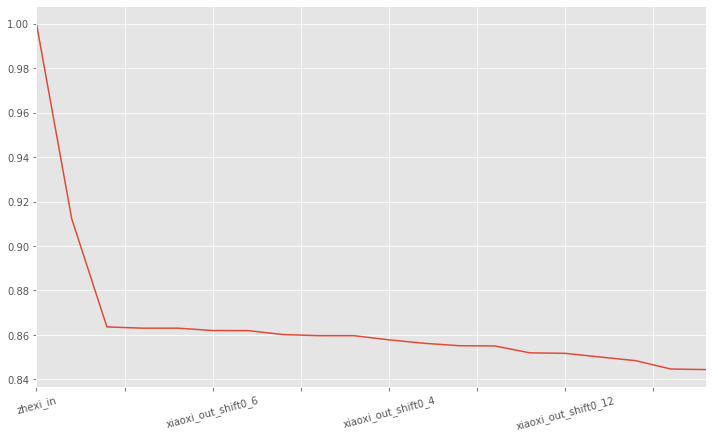

zhexi_in                       1.000000
zhexi_in_day_avg               0.912279
xiaoxi_out_day_avg             0.863586
xiaoxi_out_shift0_7            0.863037
xiaoxi_out_shift0_8            0.863036
xiaoxi_out_shift0_6            0.861972
xiaoxi_out_shift0_9            0.861943
xiaoxi_out_shift0_5            0.860158
xiaoxi_out_shift0_10           0.859664
xiaoxi_out_day_avg_shift0_1    0.859655
xiaoxi_out_shift0_4            0.857795
xiaoxi_out_shift0_11           0.856229
xiaoxi_out_day_avg_shift0_2    0.855136
xiaoxi_out_shift0_3            0.855040
xiaoxi_out_shift0_2            0.851930
xiaoxi_out_shift0_12           0.851710
xiaoxi_out_day_avg_shift0_3    0.850044
xiaoxi_out_shift0_1            0.848420
xiaoxi_out                     0.844658
xiaoxi_out_day_avg_shift0_4    0.844394
dtype: float64

In [30]:
source_df.corrwith(source_df['zhexi_in']).abs().sort_values(ascending=False).head(20).plot()
plt.xticks(rotation=15)
plt.show()
source_df.corrwith(source_df['zhexi_in']).abs().sort_values(ascending=False).head(20)

In [39]:
def whole_flow(source_df):
    source_df = handle_outlier_points(source_df)
    source_df = handle_nan(source_df)
    source_df = water_avg(source_df)
    source_df = rainfall_total(source_df)
    source_df = rainfall_heavy(source_df)
    return source_df

## Note： offset 和 period 是一个超参数，可以用贝叶斯优化调节超参数

In [105]:
train_file_name = '../input/years/2015_year.csv'  
test_file_name = '../input/years/2016_year.csv'  
train_df = load_data(file_name=train_file_name,start_point='2015/1/1 0:00:00')
test_df = load_data(file_name=test_file_name,start_point='2016/1/1 0:00:00')
train_df = whole_flow(train_df)
test_df = whole_flow(test_df)

zhexi in negtive points num: 10
zhexi_in negtive points num: 0
xiaoxi out negtive points num: 0
xiaoxi out negtive points num: 0
True    8760
Name: zhexi_in, dtype: int64
True    8760
Name: xiaoxi_out, dtype: int64
True    8760
Name: lengshuijiang_add, dtype: int64
True    8760
Name: xinhua_add, dtype: int64
True    8760
Name: zhexi_add, dtype: int64


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

zhexi in negtive points num: 0
zhexi_in negtive points num: 0
xiaoxi out negtive points num: 93
xiaoxi out negtive points num: 0
True    8780
Name: zhexi_in, dtype: int64
True    8780
Name: xiaoxi_out, dtype: int64
True    8780
Name: lengshuijiang_add, dtype: int64
True    8780
Name: xinhua_add, dtype: int64
True    8780
Name: zhexi_add, dtype: int64


In [107]:
train_array = np.array(train_df)
print(train_array.shape)
df = pd.DataFrame(train_array,columns=train_df.columns)
# df

(8737, 25)


In [108]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

columns = ['xiaoxi_out','xiaoxi_out_day_avg','zhexi_in','zhexi_in_day_avg']

In [113]:
bounds = {'offset':(36,72),'period':(5,25)}

def opt_func(array=train_array,offset=None,period=None):
    offset = np.int16(offset)
    period = np.int16(period)
    df = pd.DataFrame(array,columns=train_df.columns)
    df = create_shift_features(df,columns,[0,0,offset,offset],[period,period,period,period])
    train_array = np.array(df)
    print(train_array.shape)
    X_train, X_test, y_train, y_test = train_test_split(train_array[:,1:],train_array[:,0].reshape((-1,1)),test_size=0.18,random_state=11)
    model = BayesianRidge()
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    df = None
    return -mean_squared_error(yhat,y_test)

optimizer = BayesianOptimization(f=opt_func, pbounds=bounds, random_state=11)

In [115]:
optimizer.maximize(init_points=10,n_iter=10)
print(optimizer.max)

|   iter    |  target   |  offset   |  period   |
-------------------------------------------------
(8653, 109)
|  21       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8678, 69)
|  22       | -4.498e+0 |  48.41    |  11.38    |
(8691, 49)
|  23       | -3.219e+0 |  40.02    |  6.679    |
(8660, 89)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


|  24       | -4.122e+0 |  61.66    |  16.99    |
(8685, 81)
|  25       | -2.74e+04 |  38.0     |  14.6     |
(8666, 109)

/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



|  26       | -3.299e+0 |  50.46    |  21.96    |
(8659, 93)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


|  27       | -3.957e+0 |  61.84    |  17.04    |
(8659, 117)
|  28       | -4.309e+0 |  55.89    |  23.98    |
(8655, 69)
|  29       | -2.528e+0 |  71.52    |  11.76    |
(8673, 105)
|  30       | -2.64e+04 |  44.64    |  20.93    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  31       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  32       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  33       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  34       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  35       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  36       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  37       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  38       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  39       | -2.304e+0 |  63.32    |  21.37    |


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)
|  40       | -2.304e+0 |  63.32    |  21.37    |
{'target': -23043.195302310647, 'params': {'offset': 63.323265173778196, 'period': 21.36550715728287}}


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
#另外一个优化包

from skopt import gp_minimize

def f(x,array=train_array):
    offset = np.int16(x[0])
    period = np.int16(x[1])
    df = pd.DataFrame(array,columns=train_df.columns)
    df = create_shift_features(df,columns,[0,0,x[0],x[0]],[x[1],x[1],x[1],x[1]])
    train_array = np.array(df)
    print(train_array.shape)
    X_train, X_test, y_train, y_test = train_test_split(train_array[:,1:],train_array[:,0].reshape((-1,1)),test_size=0.18,random_state=11)
    model = BayesianRidge()
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    df = None
    return mean_squared_error(yhat,y_test)

res = gp_minimize(f,                  # the function to minimize
                  [(36,72),(5,25)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=150,         # the number of evaluations of f 
                  n_random_starts=5,  # the number of random initialization points
#                   noise=0.1**2,       # the noise level (optional)
                  random_state=123)   # the random seed

(8661, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8657, 101)
(8662, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8669, 93)
(8683, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 101)
(8665, 69)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8670, 113)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8675, 69)
(8650, 101)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8660, 61)
(8664, 93)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8681, 93)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8660, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8643, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8687, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8674, 97)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8672, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8678, 113)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8654, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8661, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8680, 49)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8668, 73)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8648, 93)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8691, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8678, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8669, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8666, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8662, 101)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8674, 65)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8646, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 65)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8666, 69)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8673, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8664, 73)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8670, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8682, 65)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8650, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8675, 97)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8675, 85)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8657, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8676, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8647, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8675, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8645, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8688, 45)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8646, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8658, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8677, 85)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8675, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8672, 53)
(8681, 85)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8649, 93)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8665, 89)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8644, 113)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8646, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8667, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8682, 89)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8683, 77)
(8682, 97)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8679, 49)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8694, 49)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8663, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8651, 101)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8674, 45)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8672, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8676, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8670, 105)
(8670, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8682, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8646, 117)
(8648, 97)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8665, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8657, 61)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8676, 69)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8677, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8662, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8682, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8658, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8665, 101)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8681, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8674, 49)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8664, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 85)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8663, 89)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8680, 45)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8656, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8663, 45)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8678, 85)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8679, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8674, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8672, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8677, 101)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 113)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8675, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8668, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8690, 45)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8665, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8662, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8681, 93)
(8654, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8662, 45)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8658, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8682, 65)
(8663, 61)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8663, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8672, 125)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 85)
(8671, 85)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8679, 97)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8644, 113)
(8685, 45)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8676, 97)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8652, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8686, 65)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8689, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8688, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8679, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 57)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8649, 125)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8674, 49)
(8675, 61)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8683, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8670, 49)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8686, 61)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8684, 73)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8681, 69)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8662, 69)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8672, 49)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8660, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8669, 77)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8671, 81)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8668, 117)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8653, 105)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8664, 85)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8657, 73)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8664, 109)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8677, 109)
(8661, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8657, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8687, 49)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8670, 53)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(8659, 117)
(8659, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [128]:
res.x[0],res.x[1], res.fun


(59, 24, 22934.690962231234)

In [130]:
train_df = create_shift_features(train_df,columns,[0,0,59,59],[24,24,24,24])
train_array = np.array(train_df)
print(train_array.shape)
X_train, X_test, y_train, y_test = train_test_split(train_array[:,1:],train_array[:,0].reshape((-1,1)),test_size=0.18,random_state=11)
model = BayesianRidge()
model.fit(X_train,y_train)
yhat = model.predict(X_test)

(8654, 121)


/home/harrison/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, '24216.160822988582')

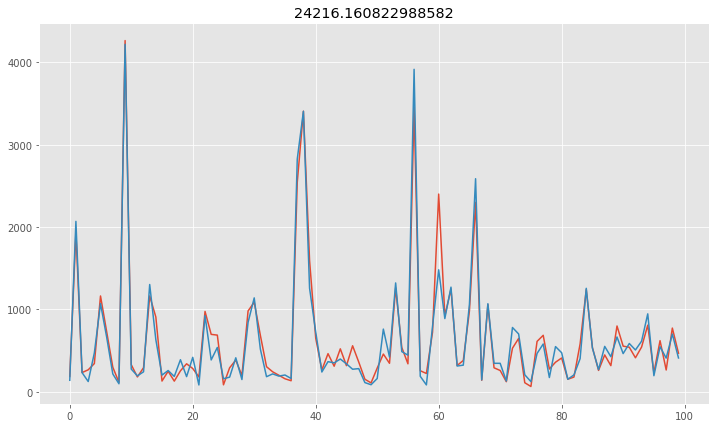

In [136]:
y_pred = yhat[:100]
y_true = y_test[:100]
plt.plot(y_pred)
plt.plot(y_true)
plt.title(mean_squared_error(y_pred,y_true))